In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

from jax import jit, value_and_grad, random
import jax.numpy as jnp
from jax.experimental import stax, optimizers

# Synthetic data generation

We choose our conditional pdf to be
$$
\rho(y | x) \sim \mathcal{N}(\cos(x), 1.5 - \sin(x))
$$
and $x \sim \mathcal{U}(0, \pi)$.

In [103]:
def generate_synthetic_data(rng, n_points):
    
    x_vals = rng.uniform(low=0.0, high=np.pi, size=n_points)
    
    #y_vals = np.cos(x_vals) + (1.5 - np.sin(x_vals)) * rng.normal(loc=0.0, scale=1.0, size=n_points)
    y_vals = 0.5*x_vals + 2.0*x_vals * rng.normal(loc=0.0, scale=1.0, size=n_points)
    
    return x_vals, y_vals

In [104]:
def get_conditional_ppf(x_vals, quantile, h=0.01):
    x_vals = np.arange(start=x_vals.min(), stop=x_vals.max(), step=h)
    #ppf_vals = np.cos(x_vals) + (1.5 - np.sin(x_vals)) * scipy.stats.norm.ppf(quantile)
    ppf_vals = 0.5*x_vals + 2.0 * x_vals * scipy.stats.norm.ppf(quantile)
    return x_vals, ppf_vals

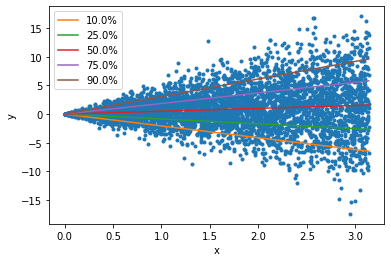

In [105]:
dataset = generate_synthetic_data(np.random.RandomState(123), 5000)

plt.plot(dataset[0], dataset[1], '.')
plt.xlabel('x')
plt.ylabel('y')

for q in [0.1, 0.25, 0.5, 0.75, 0.9]:
    x, y = get_conditional_ppf(dataset[0], q)
    plt.plot(x, y, label=f'{100.0*q}%')
plt.legend()

The curves in the plot above show the value of y such that, conditioned on x, y will lie on or below this value with a certain probability (e.g. 10% for the yellow curve).

These curves are what we aim to predict.

# Model

In [106]:
rng_key = random.PRNGKey(1234)
batch_size = 128
num_features = 1
num_batches = 10001
print_batch_freq = 500

In [107]:
init_fun, mlp_fun = stax.serial(
    stax.Dense(128),
    stax.Relu,
    stax.Dense(128),
    stax.Relu,
    stax.Dense(1)
)

_, params = init_fun(rng_key, (batch_size, num_features + 1))

This loss function is a bit unsual. As well as features, x, and ground-truth, y, we also feed in a quantile, q, for each sample.
$$
l(\hat{y}, q, y) = q (y - \hat{y})^+ + (1-q) (y - \hat{y})^-
$$
This is minimized at $\hat{y}$ such that $P(y < \hat{y}) = q$.

In [108]:
def asymmetric_mae_loss(params, x, q, y):
    x_extended = jnp.hstack([x, q.reshape((-1, 1))])
    preds = mlp_fun(params, x_extended).reshape(-1)
    err = y - preds
    pos_err = jnp.clip(err, a_min=0.0)
    neg_err = -jnp.clip(err, a_max=0.0)
    return jnp.mean(q*pos_err + (1-q)*neg_err)

In [109]:
@jit
def update(params, x, q, y, opt_state):
    loss, grads = value_and_grad(asymmetric_mae_loss)(params, x, q, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, loss

In [110]:
step_size = 1e-4
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

In [111]:
batch_rng = np.random.RandomState(9876)
q_rng = np.random.RandomState(5678)

loss_acc = 0.0

for batch_idx in range(num_batches):
    data_idx = batch_rng.choice(len(dataset[0]), size=batch_size)
    x = jnp.array(dataset[0][data_idx].reshape((-1, 1)))
    y = jnp.array(dataset[1][data_idx])
    
    q = q_rng.choice([0.1, 0.25, 0.5, 0.75, 0.9], size=batch_size)
    
    params, opt_state, loss = update(params, x, q, y, opt_state)
    loss_acc += loss
    
    if batch_idx % print_batch_freq == 0:
        loss_batch_count = print_batch_freq if batch_idx > 0 else 1
        print(f'Batch: {batch_idx + 1}, loss: {loss_acc/loss_batch_count}')
        loss_acc = 0

Batch: 1, loss: 1.2249031066894531
Batch: 501, loss: 1.1544325351715088
Batch: 1001, loss: 1.0237003564834595
Batch: 1501, loss: 0.9634662866592407
Batch: 2001, loss: 0.9277815222740173
Batch: 2501, loss: 0.9172287583351135
Batch: 3001, loss: 0.8986814618110657
Batch: 3501, loss: 0.8943909406661987
Batch: 4001, loss: 0.8900664448738098
Batch: 4501, loss: 0.8973469138145447
Batch: 5001, loss: 0.8841392397880554
Batch: 5501, loss: 0.8765051960945129
Batch: 6001, loss: 0.8820220232009888
Batch: 6501, loss: 0.8821951746940613
Batch: 7001, loss: 0.8789106011390686
Batch: 7501, loss: 0.8714405298233032
Batch: 8001, loss: 0.8731924891471863
Batch: 8501, loss: 0.8683629631996155
Batch: 9001, loss: 0.8788710832595825
Batch: 9501, loss: 0.8755874633789062
Batch: 10001, loss: 0.8730452656745911


In [112]:
def get_modelled_ppf(q):
    x_vals = jnp.arange(start=0.0, stop=jnp.pi, step=0.01).reshape((-1, 1))
    q_vals = jnp.array([q for _ in x_vals])
    x_extended = jnp.hstack([x_vals, q_vals.reshape((-1, 1))])
    y_vals = mlp_fun(params, x_extended).reshape(-1)
    
    return np.array(x_vals), np.array(y_vals)

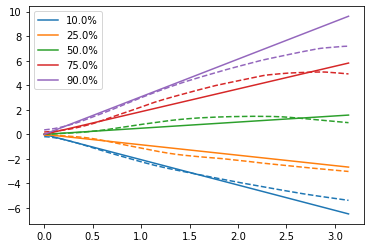

In [113]:
for q, color in zip([0.1, 0.25, 0.5, 0.75, 0.9], plt.rcParams['axes.prop_cycle'].by_key()['color']):
    # Ground truth
    x_vals, y_vals = get_conditional_ppf(dataset[0], q)
    plt.plot(x_vals, y_vals, linestyle='-', color=color, label=f'{100.0*q}%')
    # Model
    x_vals, y_vals = get_modelled_ppf(q)
    plt.plot(x_vals, y_vals, linestyle='--', color=color)
plt.legend()